In [1]:
!conda install mkl-service -y

Solving environment: done

# All requested packages already installed.



Collaborators: Erica Zhu, Noah Kaminer, Alex Cui

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, norm, uniform, binom
from ipywidgets import interact, interactive

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

In [3]:
my_binary_array = np.array([0, 0, 1, 1, 0, 1])
my_real_array = np.array([0.27, 0.34])
print(my_real_array[my_binary_array])


[0.27 0.27 0.34 0.34 0.27 0.34]


In [4]:
#her data
np.random.seed(5)

N = 100
pi = 0.3

q0 = 0.05
q1 = 0.18

n1 = int(N * pi)
n0 = N - n1

y_obs = np.zeros(N)
y_obs[:n0] = np.random.geometric(q0, size=n0)
y_obs[n0:] = np.random.geometric(q1, size=n1)

print(y_obs)

[ 5. 40.  5. 49. 14. 19. 29. 15.  7.  5.  2. 27. 12.  4. 42.  7. 11.  7.
 20. 17. 18.  7.  7.  6.  8.  4.  4. 65. 63.  5.  1.  5. 24. 30.  1. 17.
  1. 15. 20. 83.  6. 32. 40. 50.  1. 13. 78. 10. 33. 16. 29. 13.  1.  2.
  3.  6. 66. 20. 34. 17. 20. 33. 51. 48. 34.  2.  9.  1. 16. 32.  1.  2.
  3.  2.  8.  3.  6.  4.  5. 15. 15.  1. 10.  3.  1.  3.  4. 17.  3.  1.
 10.  1.  4. 10.  4.  3.  9.  1.  5.  3.]


In [5]:
#1D) Build PyMC3 model
with pm.Model() as model:
    z = pm.Bernoulli('z', p=0.3, shape=len(y_obs))
    q_ = pm.Beta('q', alpha = [1, 5], beta = [5, 1], shape=2)
    x_ = pm.Geometric('x', q_[z], observed=y_obs)
    
    trace = pm.sample(1000, chains = 1, return_inferencedata=True)


Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [q]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [6]:
# Obtain 1000 samples from the posterior distribution p(q0, q1|x1, . . . , xn)
# Generate a scatterplot (one point per sample)

posterior = trace.posterior.q
posterior

<xarray.DataArray 'q' (chain: 1, draw: 1000, q_dim_0: 2)>
array([[[0.05893102, 0.53799438],
        [0.05012565, 0.55689909],
        [0.05144789, 0.46267003],
        ...,
        [0.05124101, 0.32027099],
        [0.05693146, 0.29970642],
        [0.04722409, 0.17354984]]])
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * q_dim_0  (q_dim_0) int64 0 1

In [7]:
post_DF = posterior[0].to_pandas()
post_DF

q_dim_0,0,1
draw,,
0,0.058931,0.537994
1,0.050126,0.556899
2,0.051448,0.462670
3,0.046782,0.446301
4,0.044357,0.491010
...,...,...
995,0.043824,0.402552
996,0.043824,0.402552
997,0.051241,0.320271


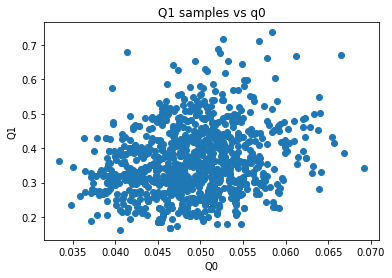

In [8]:
#samples scatter plot
plt.scatter(post_DF[0], post_DF[1])
plt.xlabel("Q0")
plt.ylabel("Q1")
plt.title("Q1 samples vs q0");

In [9]:
#ii
z_post = trace.posterior.z
z_DF = z_post[0].to_pandas() 

#Mean of number of boxes that are from Factory 1 out of 100 sampled boxes
#if Q1 > q0, sum of row must be greater than 50
z_DF["sum"] = z_DF.sum(axis=1)
z_DF[z_DF["sum"] > 50]

z_dim_0,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,sum
draw,,,,,,,,,,,,,,,,,,,,,


In [10]:
#iii
np.median(post_DF[0])

0.04890866977616526

Short Answers
 i) Q0 and q1 appear independent under the posterior distribution. The points of Q0 and Q1 show minimal correlation. This is supported by the context of the question, where each factory's defect rate does not depend on the other's.
 ii) Approximatesly 100%. There are no rows where the number of boxes from Factory 1 is greater than Factory 0. 
 iii) Median estimate of factory0's defect rate is 0.049.


In [11]:
#Q2 Use rejection sampling to generate random variables with pdf f(x) = cg(x).
# g(x) = cos2(12x) × |x3 + 6x − 2| × 1x∈(−1,−.25)∪(0,1).
def g(x):
    return abs(x**3 + 6*x - 2) * np.cos(12*x)**2 * (((x > -1) & (x < -0.25)) | ((x>0) & (x<1)))

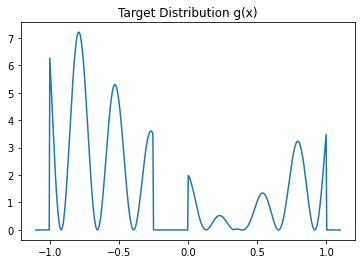

In [12]:
#Plot g(x) over its domain: -1, 1
x = np.linspace(-1.1, 1.1, 500)
g_x = g(x)
plt.plot(x, g_x)
plt.title("Target Distribution g(x)");

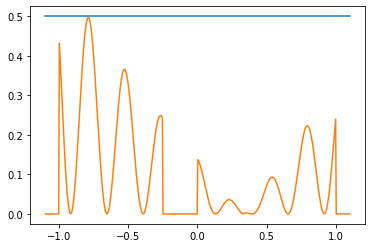

In [13]:
proposal = plt.plot(x, np.ones(500)/2)
scaled = plt.plot(x, g_x* 0.069)

In [14]:
#Taking the rejection sample
# Lab 4 Code modified
def sample_1D_proposed_distribution(N):
    """ 
    Produces N samples from the Uniform(-1,1) proposal distribution
    
    Inputs:
        N : int, desired number of samples
        
    Outputs:
        proposed_samples : an 1d-array of size N which contains N independent samples from the proposal
    """
    proposed_samples = np.random.uniform(-1, 1, (N,))
    return(proposed_samples)

# TODO: fill in
@np.vectorize
def compute_ratio_1D(proposed_sample, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample : float, proposed sample
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    ratio = (g(proposed_sample) * c) / (1/2)
    assert(ratio <= 1)
    return(ratio)

# TODO: fill in
@np.vectorize
def accept_proposal(ratio):
    """ 
    Accepts or rejects a proposal with probability equal to ratio
    
    Inputs: 
        ratio: float, probability of acceptance
    
    Outputs:
        accept: True/False, if True, accept the proposal
    """
    accept = bool(np.random.binomial(1, ratio))
    return(accept)

In [15]:
# TODO: complete the function
@np.vectorize
def get_1D_samples(N, c): 
    """ 
    Produces samples from target_1D_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : an 1d-array of which contains independent samples from the target
    """
    proposed_samples = sample_1D_proposed_distribution(N) 
    ratios = compute_ratio_1D(proposed_samples, c) 
    accept_array = accept_proposal(ratios) 
    rejection_samples = proposed_samples[accept_array]
    return(rejection_samples)

In [16]:
#Estimate c value
N = 10000
M = 0.069
rej_sample = get_1D_samples(N, M)
n = len(rej_sample)
c = M * N / n
c

0.33301158301158307

In [17]:
#2C: Use rejection sampling to generate a sample of size 10^3 from p(x)
@np.vectorize
def generate_sample(n, M):
    """
    Generate samples of size n
    Input: number of samples, int 
    Output: array of samples
    """
    samples = np.array([])
    while len(samples) < n:
        sample = get_1D_samples(1, M)
        samples = np.append(samples, sample)
    
    return samples

In [27]:
generated_samples = get_1D_samples(5000000, 0.069)

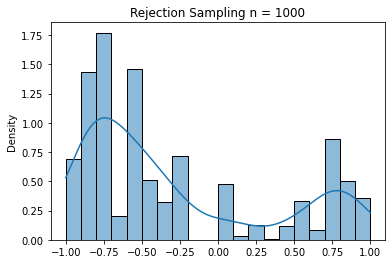

In [28]:
#Generate 10^3 samples
samples_a = generated_samples[:1000]
sns.histplot(samples_a, stat="density", kde=True, bins=20)
plt.title("Rejection Sampling n = 1000");

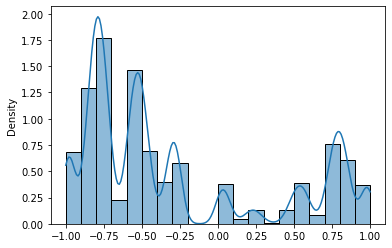

In [29]:
#10^6 samples
samples_b = generated_samples[:1000000]
sns.histplot(samples_b, stat="density", kde=True, bins=20);